In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import sys
import os

import matplotlib.pyplot as plt
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from random import randrange

import boto3

In [2]:
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from label_transforms import *

In [5]:
from s3fs.core import S3FileSystem
s3 = S3FileSystem()
from sagemaker import get_execution_role

role = get_execution_role()
bucket='files-and-examples-01'
train_file = 'datasets/su_dataset/video_data_low_level.hdf5'

train_path = s3.open('s3://{}/{}'.format(bucket, train_file))

f = h5py.File(name=train_path, mode='r')
x = np.array(f['x'])
y = np.array(f['y'])

In [6]:
def moving_average(x, w=3):
    return np.convolve(x, np.ones(w), 'valid') / w

In [7]:
x_smooth = np.apply_along_axis(moving_average, 1, x)

In [8]:
x_smooth.shape

(11062, 1547, 17)

AU01 (inner brow raiser)


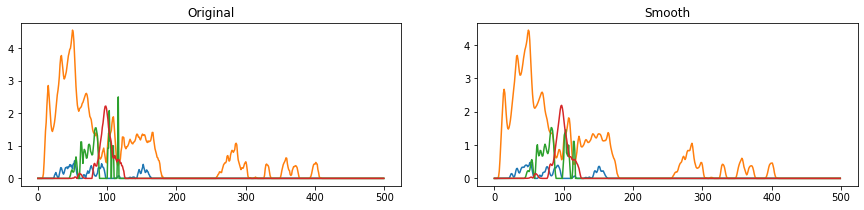

AU02 (outer brow raiser)


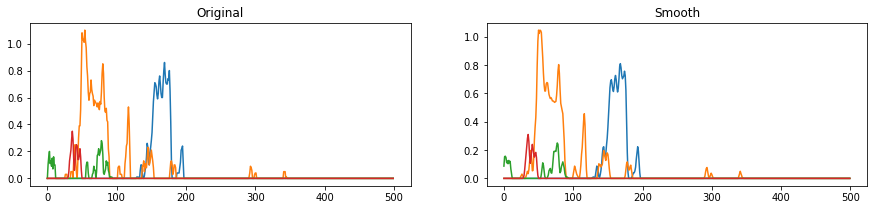

AU04 (brow lowerer)


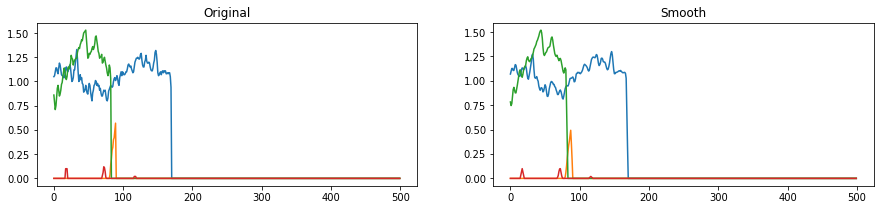

AU05 (upper lid raiser)


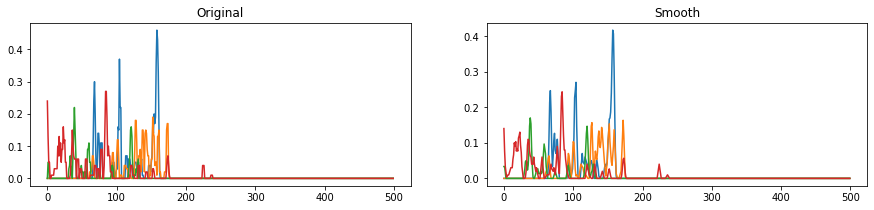

AU06 (cheek raiser)


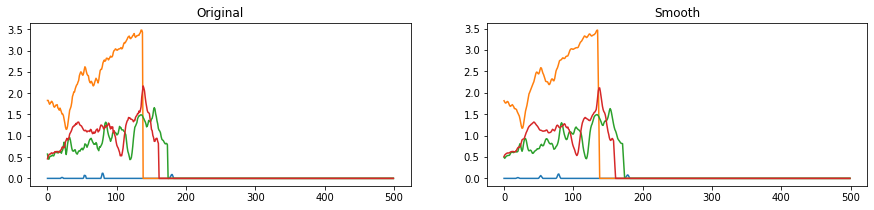

AU07 (lid tightener)


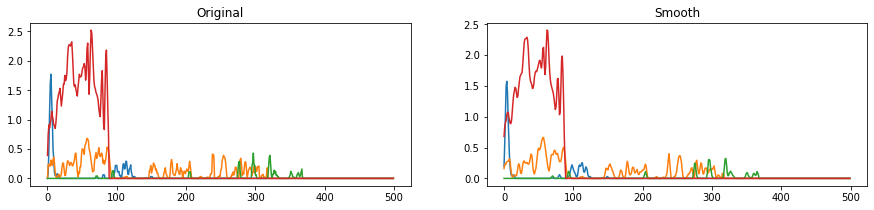

AU09 (nose wrinkler)


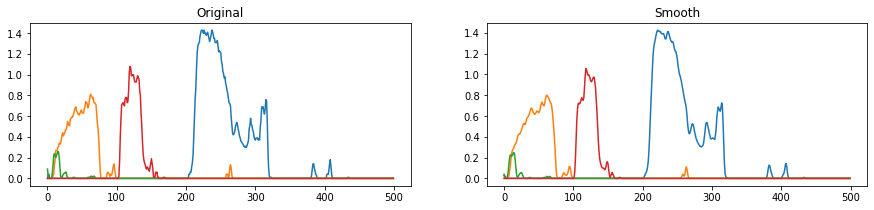

AU10 (upper lip raiser)


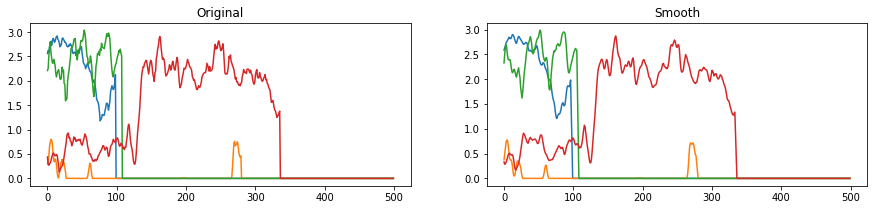

AU12 (lip corner puller)


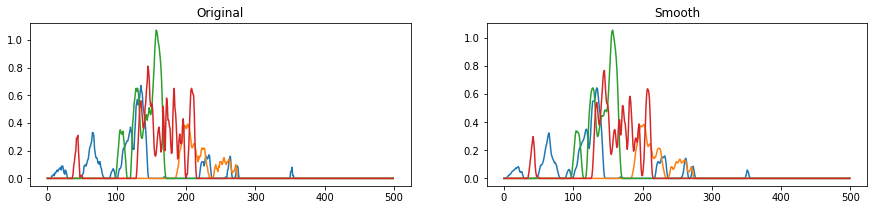

AU14 (dimpler)


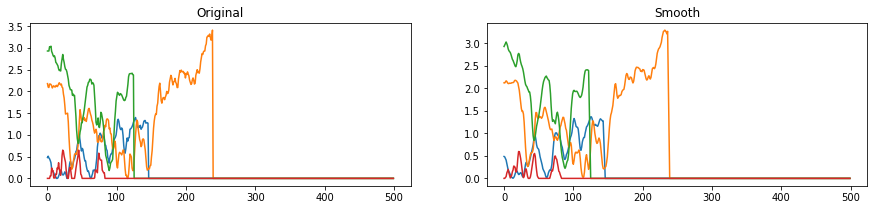

AU15 (lip corner depressor)


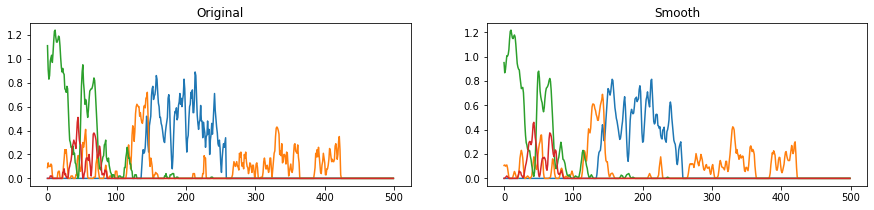

AU17 (chin raiser)


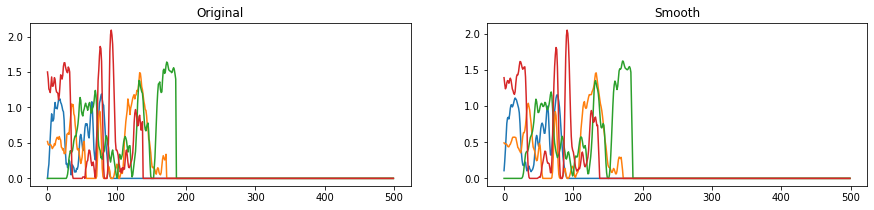

AU20 (lip stretcher)


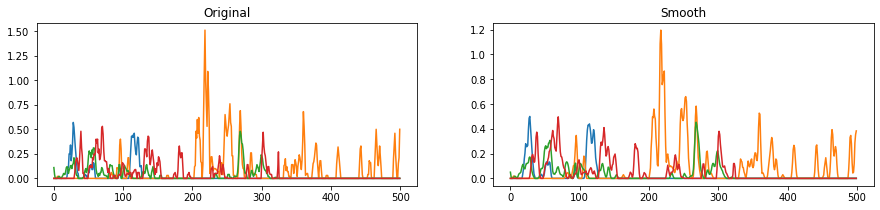

AU23 (lip tightener)


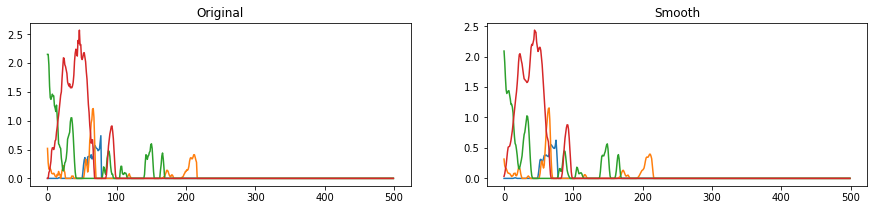

AU25 (lips part)


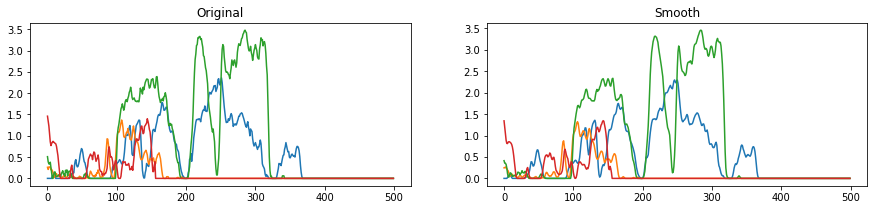

AU26 (jaw drop)


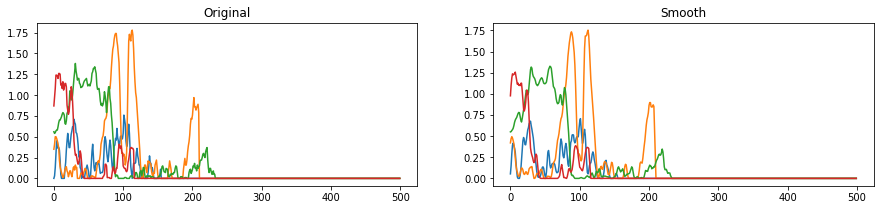

AU45 (blink)


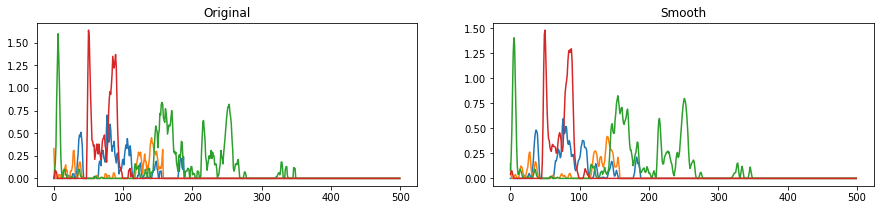

In [13]:
for au_idx, AU in enumerate(AU_INTENSITY_COLS):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
    for i in range(4):
        
        # pick a random video
        vid_idx = randrange(x_smooth.shape[0])
        
        axes[0].set_title("Original")
        axes[1].set_title("Smooth")
        ts = x[vid_idx, :500, au_idx]
        ts_smooth = x_smooth[vid_idx, :500, au_idx]
        axes[0].plot(ts)
        axes[1].plot(ts_smooth)
    print(au_intensity_name_to_desc[AU])
    plt.show()

# Basic emotions

In [186]:
ang_idx = emotion_abr_to_emotion_id["ang"]
print("ang_idx:", ang_idx)
hap_idx = emotion_abr_to_emotion_id["hap"]
print("hap_idx:", hap_idx)
sad_idx = emotion_abr_to_emotion_id["sad"]
print("sad:", sad_idx)
disg_idx = emotion_abr_to_emotion_id["disg"]
print("disg:", disg_idx)
fea_idx = emotion_abr_to_emotion_id["fea"]
print("fea:", fea_idx)

ang_idx: 12
hap_idx: 33
sad: 6
disg: 35
fea: 10


In [187]:
x_basic_emotions = x_smooth[np.where((y == ang_idx) |
                              (y == hap_idx) |
                              (y == sad_idx) |
                              (y == disg_idx) |
                              (y == fea_idx))]

y_basic_emotions = y[np.where((y == ang_idx) |
                              (y == hap_idx) |
                              (y == sad_idx) |
                              (y == disg_idx) |
                              (y == fea_idx))]

In [188]:
y_basic_emotions[y_basic_emotions == ang_idx] = 0
y_basic_emotions[y_basic_emotions == hap_idx] = 1
y_basic_emotions[y_basic_emotions == sad_idx] = 2
y_basic_emotions[y_basic_emotions == disg_idx] = 3
y_basic_emotions[y_basic_emotions == fea_idx] = 4

In [189]:
seq_len = 1547

model = keras.Sequential(
    [
        layers.LSTM(units=100,
                   return_sequences=True,
                   input_shape=(seq_len, 17)),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(100, activation="relu"),
        layers.Dense(5, activation="sigmoid")
    ]
)

In [190]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer='adam', 
              metrics=['accuracy'])

In [191]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 1547, 100)         47200     
_________________________________________________________________
dropout_12 (Dropout)         (None, 1547, 100)         0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 154700)            0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)               15470100  
_________________________________________________________________
dense_33 (Dense)             (None, 5)                 505       
Total params: 15,517,805
Trainable params: 15,517,805
Non-trainable params: 0
_________________________________________________________________


In [192]:
X_train, X_test, y_train, y_test = train_test_split(x_basic_emotions, y_basic_emotions, test_size=0.3)

In [193]:
model.fit(X_train, y_train, batch_size=100, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
9/9 [==============================] - 2s 149ms/step - loss: 1.7469 - accuracy: 0.3779 - val_loss: 1.5351 - val_accuracy: 0.4450
Epoch 2/30
9/9 [==============================] - 1s 90ms/step - loss: 1.0705 - accuracy: 0.5680 - val_loss: 1.4095 - val_accuracy: 0.4772
Epoch 3/30
9/9 [==============================] - 1s 90ms/step - loss: 0.9056 - accuracy: 0.6394 - val_loss: 1.3816 - val_accuracy: 0.5040
Epoch 4/30
9/9 [==============================] - 1s 90ms/step - loss: 0.7745 - accuracy: 0.7005 - val_loss: 1.3952 - val_accuracy: 0.5282
Epoch 5/30
9/9 [==============================] - 1s 90ms/step - loss: 0.6654 - accuracy: 0.7488 - val_loss: 1.4867 - val_accuracy: 0.5389
Epoch 6/30
9/9 [==============================] - 1s 90ms/step - loss: 0.5456 - accuracy: 0.8111 - val_loss: 1.5750 - val_accuracy: 0.5469
Epoch 7/30
9/9 [==============================] - 1s 90ms/step - loss: 0.4539 - accuracy: 0.8376 - val_loss: 1.6352 - val_accuracy: 0.5416
Epoch 8/30
9/9 [==========

# Without returning sequences

Does not work for some reason...

In [194]:
seq_len = 1547

model = keras.Sequential(
    [
        layers.LSTM(units=100,
                   input_shape=(seq_len, 17)),
        layers.Dense(100, activation="relu"),
        layers.Dense(5, activation="sigmoid")
    ]
)

In [195]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer='adam', 
              metrics=['accuracy'])

In [196]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 100)               47200     
_________________________________________________________________
dense_34 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_35 (Dense)             (None, 5)                 505       
Total params: 57,805
Trainable params: 57,805
Non-trainable params: 0
_________________________________________________________________


In [197]:
model.fit(X_train, y_train, batch_size=100, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
9/9 [==============================] - 2s 141ms/step - loss: 1.6096 - accuracy: 0.1843 - val_loss: 1.6097 - val_accuracy: 0.1743
Epoch 2/30
9/9 [==============================] - 1s 85ms/step - loss: 1.6097 - accuracy: 0.1740 - val_loss: 1.6099 - val_accuracy: 0.1743
Epoch 3/30
9/9 [==============================] - 1s 86ms/step - loss: 1.6098 - accuracy: 0.1832 - val_loss: 1.6101 - val_accuracy: 0.2011
Epoch 4/30
9/9 [==============================] - 1s 84ms/step - loss: 1.6095 - accuracy: 0.2051 - val_loss: 1.6101 - val_accuracy: 0.1984
Epoch 5/30
9/9 [==============================] - 1s 86ms/step - loss: 1.6095 - accuracy: 0.2028 - val_loss: 1.6103 - val_accuracy: 0.1984
Epoch 6/30
9/9 [==============================] - 1s 85ms/step - loss: 1.6094 - accuracy: 0.2028 - val_loss: 1.6104 - val_accuracy: 0.1984
Epoch 7/30
9/9 [==============================] - 1s 84ms/step - loss: 1.6095 - accuracy: 0.2028 - val_loss: 1.6104 - val_accuracy: 0.1984
Epoch 8/30
9/9 [==========

# All emotions

In [14]:
X_train, X_test, y_train, y_test = train_test_split(x_smooth, y, test_size=0.3)

In [136]:
X_train.shape

(7743, 1547, 17)

In [137]:
X_test.shape

(3319, 1547, 17)

In [139]:
y_train.shape

(7743,)

In [140]:
y_test.shape

(3319,)

In [142]:
np.unique(y_test)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43])

In [143]:
seq_len = 1547

model = keras.Sequential(
    [
        layers.LSTM(units=100,
                   return_sequences=True,
                   input_shape=(seq_len, 17)),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(100, activation="relu"),
        layers.Dense(44, activation="sigmoid")
    ]
)

In [144]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer='adam', 
              metrics=['accuracy'])

In [145]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 1547, 100)         47200     
_________________________________________________________________
dropout_11 (Dropout)         (None, 1547, 100)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 154700)            0         
_________________________________________________________________
dense_22 (Dense)             (None, 100)               15470100  
_________________________________________________________________
dense_23 (Dense)             (None, 44)                4444      
Total params: 15,521,744
Trainable params: 15,521,744
Non-trainable params: 0
_________________________________________________________________


In [146]:
model.fit(X_train, y_train, batch_size=100, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
78/78 [==============================] - 9s 101ms/step - loss: 3.6263 - accuracy: 0.0551 - val_loss: 3.5030 - val_accuracy: 0.0702
Epoch 2/30
78/78 [==============================] - 7s 87ms/step - loss: 3.3260 - accuracy: 0.1034 - val_loss: 3.4496 - val_accuracy: 0.0835
Epoch 3/30
78/78 [==============================] - 7s 88ms/step - loss: 3.1145 - accuracy: 0.1516 - val_loss: 3.5113 - val_accuracy: 0.0795
Epoch 4/30
78/78 [==============================] - 7s 88ms/step - loss: 2.9003 - accuracy: 0.2007 - val_loss: 3.5800 - val_accuracy: 0.0823
Epoch 5/30
78/78 [==============================] - 7s 88ms/step - loss: 2.6635 - accuracy: 0.2659 - val_loss: 3.7412 - val_accuracy: 0.0813
Epoch 6/30
78/78 [==============================] - 7s 88ms/step - loss: 2.3976 - accuracy: 0.3331 - val_loss: 3.8425 - val_accuracy: 0.0871
Epoch 7/30
78/78 [==============================] - 7s 88ms/step - loss: 2.1299 - accuracy: 0.4013 - val_loss: 4.2278 - val_accuracy: 0.0904
Epoch 8/30
7

# Deeper networks

In [15]:
seq_len = 1547

model = keras.Sequential(
    [
        layers.LSTM(units=200,
                   return_sequences=True,
                   input_shape=(seq_len, 17)),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(100, activation="relu"),
        layers.Dense(44, activation="sigmoid")
    ]
)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer='adam', 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1547, 200)         174400    
_________________________________________________________________
dropout (Dropout)            (None, 1547, 200)         0         
_________________________________________________________________
flatten (Flatten)            (None, 309400)            0         
_________________________________________________________________
dense (Dense)                (None, 100)               30940100  
_________________________________________________________________
dense_1 (Dense)              (None, 44)                4444      
Total params: 31,118,944
Trainable params: 31,118,944
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(X_train, y_train, batch_size=100, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-10-18 08:59:59.842 tensorflow-2-6-gpu--ml-g4dn-xlarge-6f7b193ebf85c4ca6ed374f84b1e:31 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-10-18 08:59:59.902 tensorflow-2-6-gpu--ml-g4dn-xlarge-6f7b193ebf85c4ca6ed374f84b1e:31 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
78/78 [==============================] - 19s 172ms/step - loss: 3.6963 - accuracy: 0.0469 - val_loss: 3.5588 - val_accuracy: 0.0588
Epoch 2/30
78/78 [==============================] - 12s 158ms/step - loss: 3.4055 - accuracy: 0.0903 - val_loss: 3.5033 - val_accuracy: 0.0687
Epoch 3/30
78/78 [======

In [18]:
seq_len = 1547

model = keras.Sequential(
    [
        layers.LSTM(units=400,
                   return_sequences=True,
                   input_shape=(seq_len, 17)),
        layers.Dropout(0.7),
        layers.Flatten(),
        layers.Dense(100, activation="relu"),
        layers.Dense(44, activation="sigmoid")
    ]
)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer='adam', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1547, 400)         668800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1547, 400)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 618800)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               61880100  
_________________________________________________________________
dense_5 (Dense)              (None, 44)                4444      
Total params: 62,553,344
Trainable params: 62,553,344
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(X_train, y_train, batch_size=100, epochs=25, validation_data=(X_test, y_test))

Epoch 1/25
78/78 [==============================] - 35s 430ms/step - loss: 3.7024 - accuracy: 0.0449 - val_loss: 3.5518 - val_accuracy: 0.0606
Epoch 2/25
78/78 [==============================] - 33s 422ms/step - loss: 3.3655 - accuracy: 0.1003 - val_loss: 3.4795 - val_accuracy: 0.0675
Epoch 3/25
78/78 [==============================] - 34s 431ms/step - loss: 3.1628 - accuracy: 0.1444 - val_loss: 3.5678 - val_accuracy: 0.0714
Epoch 4/25
78/78 [==============================] - 34s 436ms/step - loss: 2.9556 - accuracy: 0.1927 - val_loss: 3.6057 - val_accuracy: 0.0750
Epoch 5/25
78/78 [==============================] - 34s 436ms/step - loss: 2.7330 - accuracy: 0.2432 - val_loss: 3.7681 - val_accuracy: 0.0684
Epoch 6/25
78/78 [==============================] - 34s 435ms/step - loss: 2.4752 - accuracy: 0.3097 - val_loss: 4.0299 - val_accuracy: 0.0708
Epoch 7/25
78/78 [==============================] - 34s 435ms/step - loss: 2.2012 - accuracy: 0.3805 - val_loss: 4.3840 - val_accuracy: 0.0699

# Masking

Run o

In [4]:
from s3fs.core import S3FileSystem
s3 = S3FileSystem()
from sagemaker import get_execution_role

role = get_execution_role()
bucket='files-and-examples-01'
train_file = 'datasets/su_dataset/video_data_low_level_custom_pad.npz'

train_path = s3.open('s3://{}/{}'.format(bucket, train_file))

f = np.load(train_path)

x = f['x']
y = f['y']

In [5]:
f.close()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [10]:
seq_len = 1549

model = keras.Sequential(
    [
        layers.Masking(mask_value = -10, input_shape=(seq_len, 17)),
        layers.LSTM(units=100,
                   return_sequences=True,
                   input_shape=(seq_len, 17)),
        layers.Dropout(0.7),
        layers.Flatten(),
        layers.Dense(100, activation="relu"),
        layers.Dense(44, activation="sigmoid")
    ]
)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer='adam', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 1549, 17)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1549, 100)         47200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1549, 100)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 154900)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               15490100  
_________________________________________________________________
dense_3 (Dense)              (None, 44)                4444      
Total params: 15,541,744
Trainable params: 15,541,744
Non-trainable params: 0
__________________________________________

In [ ]:
model.fit(X_train, y_train, batch_size=100, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
78/78 [==============================] - 9s 79ms/step - loss: 3.6102 - accuracy: 0.0577 - val_loss: 3.4617 - val_accuracy: 0.0780
Epoch 2/50
78/78 [==============================] - 5s 59ms/step - loss: 3.3024 - accuracy: 0.1096 - val_loss: 3.4227 - val_accuracy: 0.0910
Epoch 3/50
78/78 [==============================] - 5s 59ms/step - loss: 3.0811 - accuracy: 0.1572 - val_loss: 3.4459 - val_accuracy: 0.0964
Epoch 4/50
78/78 [==============================] - 5s 59ms/step - loss: 2.8422 - accuracy: 0.2132 - val_loss: 3.5339 - val_accuracy: 0.1000
Epoch 5/50
78/78 [==============================] - 5s 58ms/step - loss: 2.5746 - accuracy: 0.2819 - val_loss: 3.6438 - val_accuracy: 0.0997
Epoch 6/50
78/78 [==============================] - 5s 58ms/step - loss: 2.3160 - accuracy: 0.3493 - val_loss: 3.8810 - val_accuracy: 0.0955
Epoch 7/50
78/78 [==============================] - 5s 58ms/step - loss: 2.0788 - accuracy: 0.4179 - val_loss: 4.0933 - val_accuracy: 0.0994
Epoch 8/50
78